# **Section:** Feature importance

In [2]:
import os
import itertools as it
import warnings
import time
import pickle

import numpy as np

import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns

import joblib

import pathlib

from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import DataConversionWarning
from sklearn.model_selection import (
    KFold, StratifiedKFold, train_test_split)

from sklearn import metrics

import tqdm

from libs.container import Container
from libs.nearest import nearest
from libs.experiment import WithAnotherExperiment, roc, metrics
from libs.precstar import  prec_star

warnings.simplefilter("ignore", category=DataConversionWarning)

/home/jbcabral/miniconda2/envs/howfar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.ranking module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
PATH = pathlib.Path(os.path.abspath(os.path.dirname("")))

DATA_PATH = PATH / "_data"

COLUMNS_NO_FEATURES = ['id', 'tile', 'cnt', 'ra_k', 'dec_k', 'vs_type', 'vs_catalog', 'cls'] 

tiles = ["b234", "b360", "b278", "b261"]

In [4]:
%%time

path = "_data/full_scaled.pkl.bz2"


train_datas = {}

sample = pd.read_pickle(path)

# the features
X_columns = [c for c in sample.columns if c not in COLUMNS_NO_FEATURES]
y_column = "cls"

sample[X_columns] =  sample[X_columns].astype(np.float32)

data = sample

del sample

CPU times: user 6min 20s, sys: 3min 20s, total: 9min 41s
Wall time: 1min 51s


In [5]:
%%time

path = "_data/full.pkl.bz2"

full = pd.read_pickle(path)

full[X_columns] =  full[X_columns].astype(np.float32)

CPU times: user 2min 12s, sys: 3.71 s, total: 2min 16s
Wall time: 1min 18s


## Run the classifiers with the selected parameters

In [6]:
RF_PARAMS = joblib.load("_cache/best_params.pkl.bz2")["rf"]
if "n_jobs" in RF_PARAMS:
    del RF_PARAMS["n_jobs"]
RF_PARAMS

{'criterion': 'entropy',
 'max_features': 'log2',
 'min_samples_split': 2,
 'n_estimators': 500}

In [7]:
data.head()

,id,tile,cnt,ra_k,dec_k,vs_type,vs_catalog,cls,Amplitude,Autocor_length,...,c89_jk_color,c89_m2,c89_m4,n09_c3,n09_hk_color,n09_jh_color,n09_jk_color,n09_m2,n09_m4,ppmb
0,32340000000806,b234,41,272.562,-34.966914,,b'',0,3.460748,-0.140552,...,0.635333,0.020208,0.015012,0.560666,0.091271,0.791673,0.627168,-0.012746,-0.010687,-1.027425
1,32340000000820,b234,44,272.573,-34.971789,,b'',0,1.717277,-0.140552,...,-0.716480,0.711469,0.722400,-0.741885,-0.040919,-0.954282,-0.723158,0.660399,0.657660,-1.116339
2,32340000000850,b234,30,272.499,-34.939850,,b'',0,3.408234,-0.140552,...,-0.695855,-0.659357,-0.646605,-0.650082,-0.096754,-0.892699,-0.704273,-0.752907,-0.755926,-0.900573
3,32340000000856,b234,62,272.487,-34.934419,,b'',0,1.924708,-0.140552,...,1.457612,0.357745,0.361937,-0.419404,1.390378,1.066175,1.446826,0.362618,0.360686,-1.028722
4,32340000000876,b234,31,272.527,-34.952167,,b'',0,4.048907,-0.140552,...,0.524965,-0.143754,-0.141476,-0.065712,0.431997,0.420317,0.515205,-0.183457,-0.184294,-0.900247


In [12]:
%%time
clf = RandomForestClassifier(n_jobs=-1, oob_score=True, **RF_PARAMS)
clf.fit(data[X_columns].values, data.cls.values)

CPU times: user 7h 24min 26s, sys: 1h 12min 35s, total: 8h 37min 2s
Wall time: 16min 36s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [13]:
joblib.dump(clf, "_cache/feat_importance_b.pkl.bz2", compress=3)

['_cache/feat_importance_b.pkl.bz2']

In [17]:
probabilities = clf.oob_decision_function_
prec, recs, thrs = metrics.precision_recall_curve(
        data.cls.values, probabilities[:,1], pos_label=1)

In [19]:
idx = nearest(recs, .9)
thr = thrs[idx]
thr, prec[idx], recs[idx]

(0.0043859649122807015, 0.017364080032623422, 0.890087660148348)

In [20]:
predictions = (probabilities[:,1] >= thr).astype(int)

In [22]:
df = pd.DataFrame({"cls": data.cls.values, "predictions": predictions})
df = df[df.cls == 1]
df["FP"] = (df.cls != df.predictions).astype(int)

In [23]:
df.describe()

,cls,predictions,FP
count,1483.0,1483.000000,1483.000000
mean,1.0,0.890088,0.109912
std,0.0,0.312886,0.312886
min,1.0,0.000000,0.000000
25%,1.0,1.000000,0.000000
50%,1.0,1.000000,0.000000
75%,1.0,1.000000,0.000000
max,1.0,1.000000,1.000000


## ponemos estas nuevas clases

In [25]:
data["predictions"] = predictions

# nos quedamos solo con las clases positivas
rr = data[data.cls == 1].copy()

# cambiamos "predictions" en FP y FN

def to_tpfn(row):
    return "TP" if row.predictions else "FN"
    

rr["clf_as"] = rr.apply(to_tpfn, axis=1)

In [30]:
clf = RandomForestClassifier(n_jobs=-1, random_state=42, oob_score=True, **RF_PARAMS)

In [31]:
clf.fit(rr[X_columns].values, rr.predictions.values)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [32]:
fimp = pd.DataFrame({"Feature": X_columns, "Importance": clf.feature_importances_})
fimp = fimp.sort_values("Importance").reset_index()
fimp.tail()

,index,Feature,Importance
57,42,Psi_CS,0.039090
58,61,ppmb,0.042666
59,40,PeriodLS,0.062514
60,43,Psi_eta,0.076996
61,41,Period_fit,0.107361


In [33]:
from matplotlib.cbook import boxplot_stats    

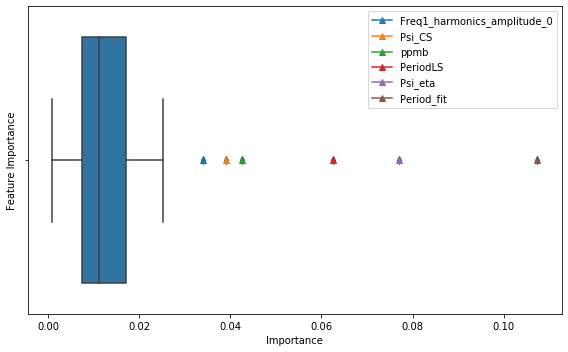

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

outliers = boxplot_stats(fimp.Importance)[0]["fliers"]
feat_outs = []

sns.boxplot(fimp.Importance, ax=ax)
for flier in outliers:
    feat = fimp[fimp.Importance == flier].Feature.values[0]
    feat_outs.append(feat)
    ax.plot([flier], [0], marker='^', label=feat)

ax.set_ylabel("Feature Importance")
ax.legend()

fig.tight_layout()

In [35]:
def get_clf_as(sid):
    return rr[rr.id == sid].clf_as.values[0]

real_rr = full[full.id.isin(rr.id)].copy()
real_rr["clf_as"] = real_rr.id.apply(get_clf_as)
real_rr = real_rr[["id", "cls", "clf_as", "vs_type"] + feat_outs]
real_rr

,id,cls,clf_as,vs_type,Freq1_harmonics_amplitude_0,Psi_CS,ppmb,PeriodLS,Psi_eta,Period_fit
1111,32340000004025,1,TP,RRLyr-RRc,0.041822,0.167389,8.257149,0.105753,1.818878,1.000000
5994,32340000017286,1,FN,RRLyr-RRab,0.050845,0.188947,4.663693,0.172709,2.101878,1.000000
14929,32340000042102,1,TP,RRLyr-RRab,0.127633,0.212557,1.998425,0.477552,0.237338,0.000002
15117,32340000040972,1,TP,RRLyr-RRab,0.088784,0.251060,1.805869,0.504065,0.628734,0.000004
20942,32340000057716,1,TP,RRLyr-RRc,0.046085,0.175770,2.582238,0.306671,1.382572,0.000000
...,...,...,...,...,...,...,...,...,...,...
2521122,32610000843124,1,TP,RRLyr-RRab,0.115530,0.222207,1.738406,0.550237,0.158531,0.000000
2521679,32610000843936,1,FN,RRLyr-RRc,0.011914,0.158619,1.851285,0.497939,1.790764,1.000000
2523069,32610000846013,1,TP,RRLyr-RRab,0.097589,0.258422,1.570256,0.534404,0.341349,0.000000
2523461,32610000846610,1,TP,RRLyr-RRab,0.117954,0.306282,1.690459,0.512729,0.248777,0.000000


In [36]:
outlimit = min(boxplot_stats(real_rr.PeriodLS.values)[0]['fliers'])
outlimit

0.97553897

In [37]:
real_rr = real_rr[real_rr.PeriodLS.between(0, outlimit)]

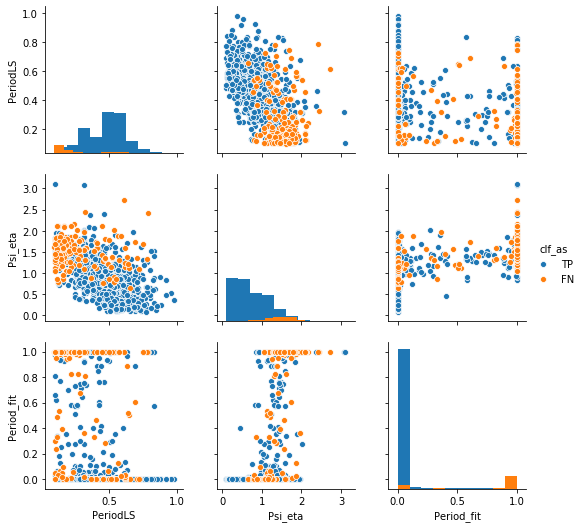

In [39]:
sns.pairplot(
    real_rr, 
    hue="clf_as", 
    vars=feat_outs[-3:], 
    diag_kind="hist")

/home/jbcabral/miniconda2/envs/howfar/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/jbcabral/miniconda2/envs/howfar/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


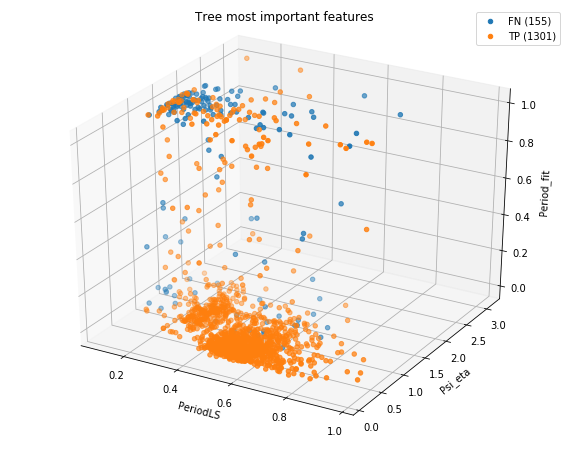

In [41]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

fn = real_rr[rr.clf_as == "FN"]
params = [fn[k].values for k in feat_outs[-3:]]
ax.scatter(*params, label=f"FN ({len(fn)})")

tp = real_rr[rr.clf_as == "TP"]
params = [tp[k].values for k in feat_outs[-3:]]
ax.scatter(*params, label=f"TP ({len(tp)})")

ax.set_xlabel(feat_outs[-3])
ax.set_ylabel(feat_outs[-2])
ax.set_zlabel(feat_outs[-1])

ax.set_title(f"Tree most important features \n")

ax.legend();

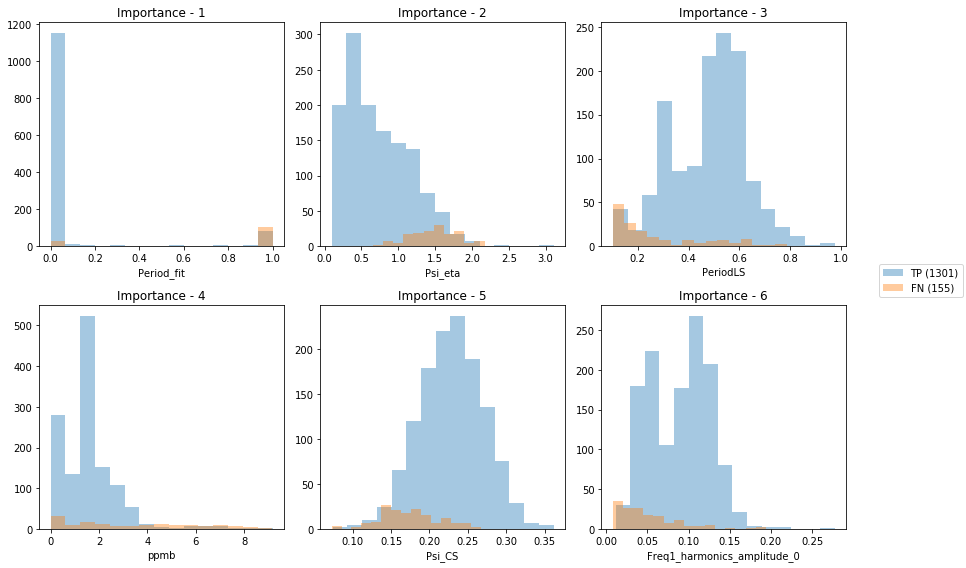

In [50]:
fig, axes = plt.subplots(2, int(len(feat_outs)/2), figsize=(12, 8))

bins=15; 
for idx, oname, ax in zip(range(len(feat_outs)), feat_outs[::-1], it.chain(*axes)):    
    tp_label, fn_label = (
        (f"TP ({len(tp)})", f"FN ({len(fn)})") 
        if idx == 0 
        else ("__nolegend__", "__nolegend__"))
    sns.distplot(tp[oname], ax=ax, label=tp_label, bins=bins, kde=False, norm_hist=False)
    sns.distplot(fn[oname], ax=ax, label=fn_label, bins=bins, kde=False, norm_hist=False)
    ax.set_title(f"Importance - {idx+1}")
    
fig.legend(loc=7, bbox_to_anchor=(1.12, 0.5))
fig.tight_layout()

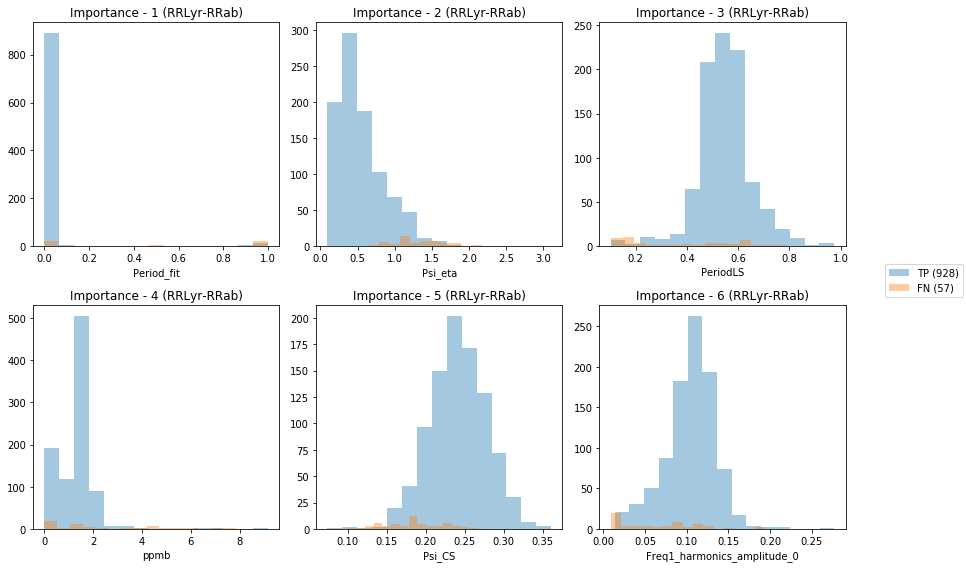

In [48]:
fig, axes = plt.subplots(2, int(len(feat_outs)/2), figsize=(12, 8))

bins=15; vs_type="RRLyr-RRab"
rrtp = tp[tp.vs_type == vs_type]
rrfn = fn[fn.vs_type == vs_type]
for idx, oname, ax in zip(range(len(feat_outs)), feat_outs[::-1], it.chain(*axes)):    
    tp_label, fn_label = (
        (f"TP ({len(rrtp)})", f"FN ({len(rrfn)})") 
        if idx == 0 
        else ("__nolegend__", "__nolegend__"))
    sns.distplot(rrtp[oname], ax=ax, label=tp_label, bins=bins, kde=False, norm_hist=False)
    sns.distplot(rrfn[oname], ax=ax, label=fn_label, bins=bins, kde=False, norm_hist=False)
    ax.set_title(f"Importance - {idx+1} ({vs_type})")
    
fig.legend(loc=7, bbox_to_anchor=(1.12, 0.5))
fig.tight_layout()

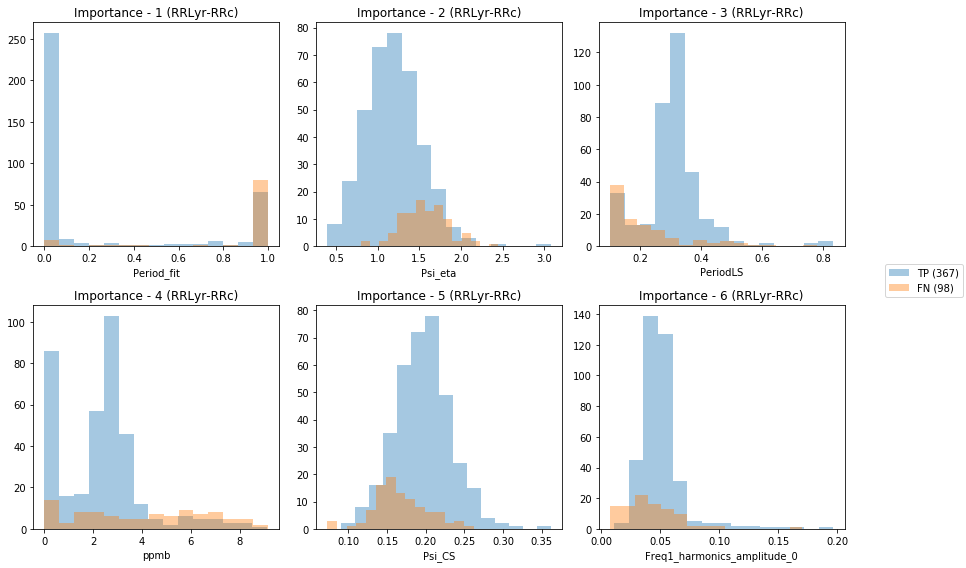

In [47]:
fig, axes = plt.subplots(2, int(len(feat_outs)/2), figsize=(12, 8))

bins=15; vs_type="RRLyr-RRc"
rrtp = tp[tp.vs_type == vs_type]
rrfn = fn[fn.vs_type == vs_type]
for idx, oname, ax in zip(range(len(feat_outs)), feat_outs[::-1], it.chain(*axes)):    
    tp_label, fn_label = (
        (f"TP ({len(rrtp)})", f"FN ({len(rrfn)})") 
        if idx == 0 
        else ("__nolegend__", "__nolegend__"))
    sns.distplot(rrtp[oname], ax=ax, label=tp_label, bins=bins, kde=False, norm_hist=False)
    sns.distplot(rrfn[oname], ax=ax, label=fn_label, bins=bins, kde=False, norm_hist=False)
    ax.set_title(f"Importance - {idx+1} ({vs_type})")
    
fig.legend(loc=7, bbox_to_anchor=(1.12, 0.5))
fig.tight_layout()

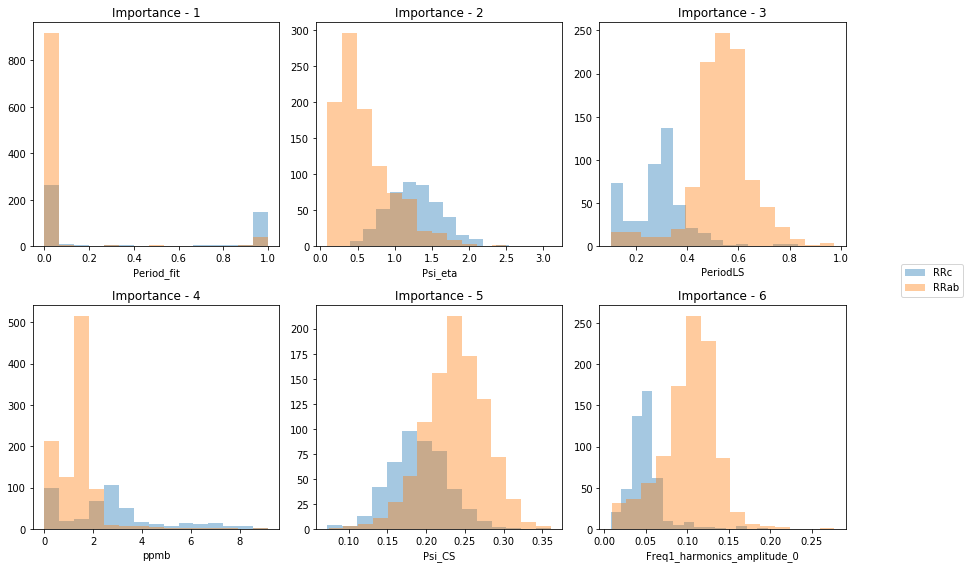

In [46]:
fig, axes = plt.subplots(2, int(len(feat_outs)/2), figsize=(12, 8))

bins=15
for idx, oname, ax in zip(range(len(feat_outs)), feat_outs[::-1], it.chain(*axes)):    
    tp_label, fn_label = (
        (f"RRc", f"RRab") 
        if idx == 0 
        else ("__nolegend__", "__nolegend__"))
    sns.distplot(real_rr[real_rr.vs_type == "RRLyr-RRc"][oname], ax=ax, label=tp_label, bins=bins, kde=False, norm_hist=False)
    sns.distplot(real_rr[real_rr.vs_type != "RRLyr-RRc"][oname], ax=ax, label=fn_label, bins=bins, kde=False, norm_hist=False)
    ax.set_title(f"Importance - {idx+1}")
    
fig.legend(loc=7, bbox_to_anchor=(1.12, 0.5))
fig.tight_layout()

In [116]:
Counter(rr[rr.clf_as=="TP"].vs_type)

Counter({'RRLyr-RRab': 277, 'RRLyr-RRc': 128})